# Development Notebook for applying Oxygen Corrections to timeseries data

- Minimally correct for Sal/Press and convert to consistent units of uM/kg
  + Also Despike or remove known bad/failing data
- Find available comparisons (in order of percieved desireability):
  + CTD w/o winkler correction (not super helpful - just a sanity check)
  + Lab in air check + NARR/UW Baro
  + Back Deck in air check (from data record) + NARR Baro
  + CTD with winkler correction
  + Direct Winkler Comparison
- Evaluate any and all scale corrections (pre/post cruise)

Save two oxygens: Sal/Press Corr only, Best Correction (indicate method somehow?)

In [165]:
import pandas as pd
import xarray as xr
import datetime
import yaml

import EcoFOCIpy.io.erddap as erddap

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

In [167]:
user_data_dir = '/Users/bell/ecoraid/2024/Moorings/24bs2c/'
mooring_meta_file = user_data_dir+'logs/24BS-2C.yaml'
dep_depth_m = 23

#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)
mooring_config['Deployment']

{'DeploymentCruise': 'DY2410',
 'DeploymentLatitude': '56 51.6123 N',
 'DeploymentLongitude': '164 03.3174 W',
 'DeploymentDateTimeGMT': datetime.datetime(2024, 9, 8, 23, 0),
 'DeploymentDepth': 72.8}

In [168]:
mooring_config['Recovery']

{'RecoveryCruise': 'DY2504',
 'RecoveryLatitude': '56 51.0 N',
 'RecoveryLongitude': '161 3.3 W',
 'RecoveryDateTimeGMT': datetime.datetime(2025, 4, 29, 16, 26),
 'RecoveryDepth': 72.8}

### load timeseries

- if preliminary is used, then oxygen not been corrected to winklers or Sal/Depth Corrected and will be in uM but will have deck data

In [169]:
url = "http://akutan.pmel.noaa.gov:8082/erddap"
sdf = erddap.erddapMooredInstretrieve(url=url,mooringid='24bs2c',qclevel='preliminary',instrid='24bs2c_s16_0023m')

### load/identify collocated cruise casts

- preliminary CTD data does not have winkler corrections

In [170]:
dep_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'dy2410',
               'qclevel':'preliminary',
               'concastno':'054' #008, 009
              }

rec_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'dy2504',
               'qclevel':'preliminary',
               'concastno':'021'
              }
               
depcast = erddap.erddapCTDretrieve(**dep_details)
reccast = erddap.erddapCTDretrieve(**rec_details)

In [171]:
dcast_closest = depcast.iloc[(depcast['pressure']-dep_depth_m).abs().argsort()[:1]]

dcast_closest[['pressure', 'O_65 (um/kg)','CTDOXY_4221 (um/kg)','OST_62 (%)','CTDOST_4220 (%)']]

,pressure,O_65 (um/kg),CTDOXY_4221 (um/kg),OST_62 (%),CTDOST_4220 (%)
6105,23.0,290.126,273.465,101.216,95.418


### is there a winkler within +/-2m of deployment depth

In [172]:
dep_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8080/erddap",
               'cruiseid':'dy2410',
               'qclevel':'final_oxy',
               'concastno':'054'
              }

rec_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8080/erddap",
               'cruiseid':'dy2504',
               'qclevel':'final_oxy',
               'concastno':'021'
              }
               
oxy_dep = erddap.erddapCTDretrieve(**dep_details)
# oxy_rec = erddap.erddapCTDretrieve(**rec_details)

In [185]:
oxy_dep

,time (UTC),pressure,latitude (degrees_north),longitude (degrees_east),bottle_oxygen (uM l-1),BTLID,profile_id,Water_Depth (m),Station_Name
74,2024-09-14T06:36:00Z,68.818,56.858665,-164.04083,235.89470,2.0,dy2410c054_oxy,72.0,M2
75,2024-09-14T06:36:00Z,68.818,56.858665,-164.04083,235.82133,2.0,dy2410c054_oxy,72.0,M2
76,2024-09-14T06:36:00Z,68.818,56.858665,-164.04083,235.60362,2.0,dy2410c054_oxy,72.0,M2
77,2024-09-14T06:36:00Z,51.487,56.858665,-164.04083,235.33772,3.0,dy2410c054_oxy,72.0,M2
78,2024-09-14T06:36:00Z,40.692,56.858665,-164.04083,235.04245,4.0,dy2410c054_oxy,72.0,M2
79,2024-09-14T06:36:00Z,21.453,56.858665,-164.04083,309.96613,7.0,dy2410c054_oxy,72.0,M2
80,2024-09-14T06:36:00Z,11.664,56.858665,-164.04083,309.08612,8.0,dy2410c054_oxy,72.0,M2
81,2024-09-14T06:36:00Z,5.595,56.858665,-164.04083,309.65915,10.0,dy2410c054_oxy,72.0,M2


In [173]:
doxy_closest = oxy_dep.iloc[(oxy_dep['pressure']-dep_depth_m).abs().argsort()[:1]]

doxy_closest[['pressure','bottle_oxygen (uM l-1)']]

,pressure,bottle_oxygen (uM l-1)
79,21.453,309.96613


In [174]:
sdf.columns = [x.split()[0] for x in sdf.columns ]

## Salinity and Depth corrections to Oxygen

FOCI sets (or keeps) all aanderaa salinity sensors at 0-PSU (factory) for simplicity and consistency and applies the salinity correction after recovery, also, we tend to report in um/kg as opposed to um/l (or Molar) so do the unit conversion too. And finally, the actual measurement made is partial pressure/ percent saturation.  Report that as well (may need to calculate it)

Salinity may not be reported on the same instrument (rcm vs sbe) so may need to massage the salinity correction

In [175]:
from EcoFOCIpy.math import aandopt_oxy_corr as aand_oxy

# if you just want to correct and move on - pass the trimmed data in e.g. : sbe16_wop_nc.autotrim_time().oxy_conc
# if you want to evaluate deck info - pass the untrimmed data in e.g. : sbe16_wop_nc.get_xdf().oxy_conc

#depth correction... usually small
temp_oxycorr = aand_oxy.o2_dep_comp(oxygen_conc=sdf.oxygen_concentration,depth=dep_depth_m)
#sal correction... big!
temp_oxycorr = aand_oxy.o2_sal_comp(oxygen_conc=temp_oxycorr,
                                    salinity=sdf.salinity,
                                    temperature=sdf.temperature)

#units adjustment... not so big
temp_oxycorr_umkg = aand_oxy.o2_molar2umkg(oxygen_conc=temp_oxycorr,
                                           salinity=sdf.salinity,
                                           temperature=sdf.temperature,
                                           pressure=dep_depth_m)

#saturation calculation
temp_oxysat = aand_oxy.o2_percent_sat(oxygen_conc=temp_oxycorr,
                                           salinity=sdf.salinity,
                                           temperature=sdf.temperature,
                                           pressure=dep_depth_m)

In [176]:
sdf['temp_oxysat'] = temp_oxysat
sdf['temp_oxycorr'] = temp_oxycorr

In [177]:
tdf = sdf.set_index(pd.to_datetime(sdf.time))

<Axes: xlabel='time'>

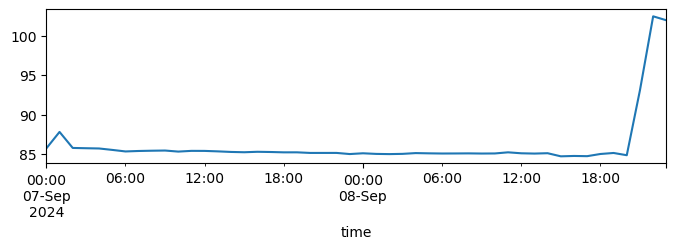

In [178]:
tdf.loc[((mooring_config['Deployment']['DeploymentDateTimeGMT']-datetime.timedelta(seconds=86400)).strftime('%Y-%m-%d')):
         (mooring_config['Deployment']['DeploymentDateTimeGMT'].strftime('%Y-%m-%d'))].temp_oxysat.plot(figsize=(8,2))

In [179]:
print(f'Average %Sat in 24 hours leading to deployment')
tdf.loc[((mooring_config['Deployment']['DeploymentDateTimeGMT']-datetime.timedelta(seconds=86400)).strftime('%Y-%m-%d')):
         (mooring_config['Deployment']['DeploymentDateTimeGMT'].strftime('%Y-%m-%d'))].temp_oxysat.mean()

Average %Sat in 24 hours leading to deployment


86.11917637203173

<Axes: xlabel='time'>

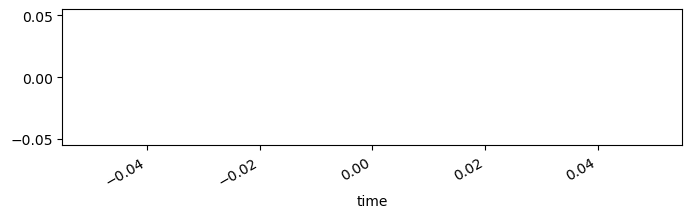

In [180]:
tdf.loc[(mooring_config['Recovery']['RecoveryDateTimeGMT'].strftime('%Y-%m-%d')):
        ((mooring_config['Recovery']['RecoveryDateTimeGMT']-datetime.timedelta(seconds=86400))
         .strftime('%Y-%m-%d'))].temp_oxysat.plot(figsize=(8,2))

In [181]:
print(f'Average %Sat in 24 hours after recovery')
tdf.loc[((mooring_config['Recovery']['RecoveryDateTimeGMT']-datetime.timedelta(seconds=86400)).strftime('%Y-%m-%d')):
         (mooring_config['Recovery']['RecoveryDateTimeGMT'].strftime('%Y-%m-%d'))].temp_oxysat.mean()

Average %Sat in 24 hours after recovery


nan

<Axes: xlabel='time'>

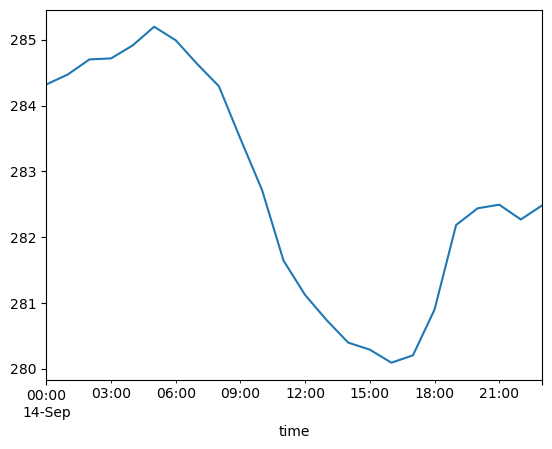

In [182]:
tdf.loc[doxy_closest['time (UTC)'].values[0].split('T')[0]]['temp_oxycorr'].plot()

In [183]:
print(f'Average %Conc on day of deployment/ctd {doxy_closest['time (UTC)'].values[0]}')
tdf.loc[doxy_closest['time (UTC)'].values[0].split('T')[0]]['temp_oxycorr'].mean()

Average %Conc on day of deployment/ctd 2024-09-14T06:36:00Z


282.7373884568161

In [184]:
print(f'Ratio of inst / winkler')
tdf.loc[doxy_closest['time (UTC)'].values[0].split('T')[0]]['temp_oxycorr'].mean() / doxy_closest['bottle_oxygen (uM l-1)']

Ratio of inst / winkler


79    0.912156
Name: bottle_oxygen (uM l-1), dtype: float64